In [19]:
# imports
import os
import pandas as pd
import numpy as np
import pickle

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.utils import resample
from sklearn.model_selection import GroupShuffleSplit

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

In [21]:
def evaluation_summary(description, true_labels, predictions):
  print("Evaluation for: " + description)
  print(classification_report(true_labels, predictions,  digits=3, zero_division=0))
  print('\nConfusion matrix:\n',confusion_matrix(true_labels, predictions))

## Import Dataset

In [2]:
# Combine dataset classes
real_df = pd.read_csv("data/FakeNewsNet/dataset/pf_real.csv")
fake_df = pd.read_csv("data/FakeNewsNet/dataset/pf_fake.csv")
fake_df['true'] = False
real_df['true'] = True
df = pd.concat([fake_df, real_df])
df.reset_index()

#print(df.head())


# Fix imbalance
# https://elitedatascience.com/imbalanced-classes
# Separate majority and minority classes
df_majority = df[df.true==True]
df_minority = df[df.true==False]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority),     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

df_downsampled = df_downsampled.sample(frac=1, random_state=111019)

df_downsampled.reset_index(inplace=True)

data_df = df_downsampled.copy()

X = data_df.drop(labels=['index', 'Unnamed: 0.1', 'Unnamed: 0', 'id', 'author_id', 'source', 'created_at', 'edit_history_tweet_ids', 'lang', 'description', 'username', 'verified', 'name', 'location', 'Unnamed: 0.2', 'true'], axis=1)
y = data_df.true

gs_1 = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=111019)
train_ix, test_ix = next(gs_1.split(X, y, groups=X.article_id))

X_test = X.iloc[test_ix]
y_test = y.iloc[test_ix]

# X_val = X.iloc[train_ix]
# y_val = y.iloc[train_ix]

In [3]:
X_test = X_test.drop('article_id', axis=1)
X_test.head()

,text
7,"@SparrowsMajor ""Yeah, yeah! I'm an Italian, on..."
12,3rd Presidential Debate: Full Video &amp; Tran...
19,BREAKING: Barrels Removed From Clinton Propert...
20,Video of kids singing praise to President Obam...
28,Saudi Arabia to Behead 6 School Girls for Bein...


In [13]:
test_text = X_test['text']

In [14]:
# Get features for TF-IDF
# tfidf = TfidfVectorizer()
# tfidf.fit(train_text)
#train_features = tfidf.transform(train_text)
test_features = tfidf.transform(test_text)

NameError: name 'tfidf' is not defined

In [ ]:
# SVC
svc = SVC(kernel='rbf')
svc_model = svc.fit(train_features, train_labels)
svc_test = svc_model.predict(test_features)
evaluation_summary("SVC test", test_labels, svc_test)

# Logistic Regression with TF-IDF
lr_tfidf = LogisticRegression()
lr_model_tfidf = lr_tfidf.fit(train_features, train_labels)
lrtfidf_test = lr_model_tfidf.predict(test_features)
evaluation_summary("LR (TF-IDF) test", test_labels, lrtfidf_test)

# Dummy Majority
dumb = DummyClassifier(strategy='most_frequent')
dumb.fit(train_features, train_labels)
dumb_test = dumb.predict(test_features)
evaluation_summary("Dummy MF test", test_labels, dumb_test)

## Make Prediction

In [ ]:
# Get output

input_text = "Watch video showing gunfire inside Canada's pa"
input_df = pd.DataFrame({"src_text": [input_text]})
input_features = tfidf.transform(input_df)

predicted_label = lr_model_tfidf.predict(input_features)

print(predicted_label)

## Test from Saved Model

In [15]:
static_path = os.path.join('web', 'fnews', 'static')

model_path = os.path.join(static_path, 'models', 'simple_model.sav')
preprocessing_path = os.path.join(static_path, 'preprocessing', 'tfidf_vectorizer.sav')

model = pickle.load(open(model_path, "rb"))
preprocessing = pickle.load(open(preprocessing_path, "rb"))

test_features = preprocessing.transform(test_text)

C:\Users\karli\.conda\envs\fnews\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.1.3 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\karli\.conda\envs\fnews\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.1.3 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\karli\.conda\envs\fnews\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.1.3 when using version 1.2.0. This might lead to breaking code or inval

In [16]:
print(test_features)

  (0, 106860)	0.41365659606501937
  (0, 96538)	0.26618049184877296
  (0, 93805)	0.06413902951935159
  (0, 88483)	0.31842637346276076
  (0, 84952)	0.14753489868209144
  (0, 73956)	0.1130617174191783
  (0, 71171)	0.1527711651494806
  (0, 71114)	0.10330626726083174
  (0, 65814)	0.13445823652095698
  (0, 62547)	0.14177562081390258
  (0, 57523)	0.2212577411031334
  (0, 53415)	0.11388364989331605
  (0, 49970)	0.2764444532684348
  (0, 49794)	0.07540785702090506
  (0, 46501)	0.11461736503154224
  (0, 34113)	0.23152170252279525
  (0, 30705)	0.29476457982534315
  (0, 20473)	0.31842637346276076
  (0, 15184)	0.1770306543883903
  (0, 14319)	0.31842637346276076
  (0, 13815)	0.11831494243523591
  (1, 99614)	0.2755187497766885
  (1, 94436)	0.3040465729170332
  (1, 76163)	0.2960437952429896
  (1, 73210)	0.40641164734736585
  :	:
  (58372, 37369)	0.24128362797810943
  (58372, 28275)	0.25784076567559316
  (58372, 28271)	0.19463750810121488
  (58372, 27763)	0.178580596530721
  (58372, 24398)	0.03185915864

In [17]:
lrtfidf_test = model.predict(test_features)

In [10]:
print(lrtfidf_test)
print(X_test)

[ True]
                                                     text
7       @SparrowsMajor "Yeah, yeah! I'm an Italian, on...
12      3rd Presidential Debate: Full Video &amp; Tran...
19      BREAKING: Barrels Removed From Clinton Propert...
20      Video of kids singing praise to President Obam...
28      Saudi Arabia to Behead 6 School Girls for Bein...
...                                                   ...
217847  CNN NEWSROOM WITH BROOKE BALDWIN (2) 11:00AM 4...
217849  Ohio student suspended for staying in class du...
217853  @tod_wei @realDonaldTrump @SecPompeo OK Point ...
217857  Great write-up of @whatknows’s interview with ...
217859  It shouldn't be too much to ask for one (1) we...

[58374 rows x 1 columns]


In [22]:
evaluation_summary("LR TF-IDF Test", y_true, y_pred)

Evaluation for: LR TF-IDF Test
              precision    recall  f1-score   support

       False      0.751     0.670     0.708     18139
        True      0.858     0.900     0.878     40235

    accuracy                          0.828     58374
   macro avg      0.805     0.785     0.793     58374
weighted avg      0.825     0.828     0.826     58374


Confusion matrix:
 [[12159  5980]
 [ 4035 36200]]


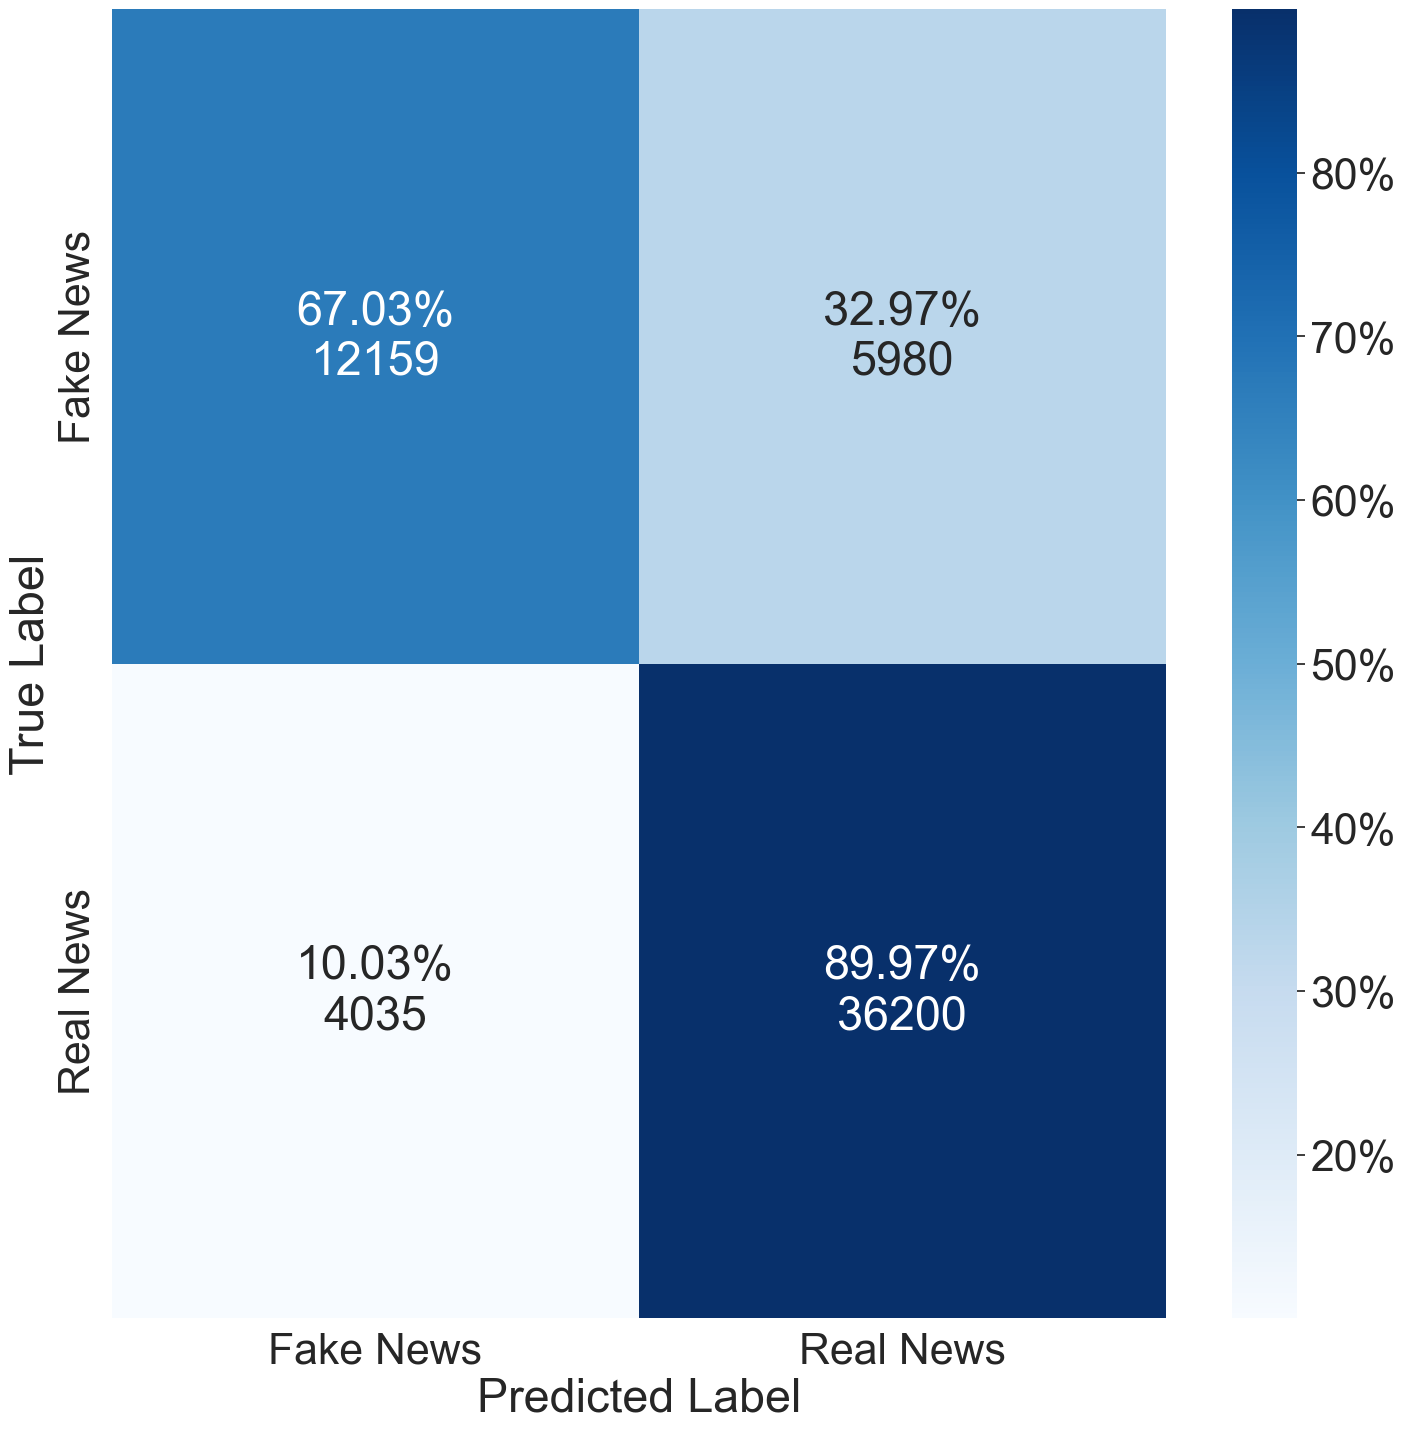

In [20]:
# Retrieved from https://gist.github.com/mesquita/f6beffcc2579c6f3a97c9d93e278a9f1

from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, filename, labels, classes, ymap=None, figsize=(17,17)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      classes:   aliases for the labels. String array to be shown in the cm plot.
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    sns.set(font_scale=2.8)

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = cm * 100
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    fig, ax = plt.subplots(figsize=figsize)
    plt.yticks(va='center')

    sns.heatmap(cm, annot=annot, fmt='', ax=ax, xticklabels=classes, cbar=True, cbar_kws={'format':PercentFormatter()}, yticklabels=classes, cmap="Blues")
    plt.savefig(filename,  bbox_inches='tight')

y_true = y_test
y_pred = lrtfidf_test

cm_analysis(y_true, y_pred, "conf.png", [0, 1], ["Fake News", "Real News"])